# **S&P 500 Stock Price Analysis -- Amazon (AMZN)**
### Author: Dragon Xu (runshenx)
### Date: 09/12/2024

In [ ]:
# Import all the packages needed to perform time series forecasting
from pandas_datareader import data as pdr #read data from yahoo finance api
import yfinance as yf
import matplotlib.pyplot as plt #viz #GUI manager
import seaborn as sns #viz #plotly is another package
import datetime
import pandas as pd
import numpy as np
from pandas import Grouper #groupby
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf #autocorrelation plot
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing
from pandas.plotting import autocorrelation_plot #autocorrelation plot
from statsmodels.graphics.gofplots import qqplot #residual diagnostics
from sklearn.metrics import mean_squared_error #accuracy metrics
from math import sqrt
from sklearn.metrics import mean_absolute_error #accuracy metrics
from random import gauss #create gaussian white noise
from random import seed
from sklearn.model_selection import train_test_split

# 3. Assess the relationship between each of the 3 economic factors and Amazon stock

Are the variables good predictors or bad predictors? Present your findings and insights using appropriate charts and graphs.

In [ ]:
# Define the global constants
start_date = datetime.datetime(2012,1,1)
end_date = datetime.datetime(2024,4,1) # Choose 2024-04-01 because it is the latest date for GDP data
stock_name = 'AMZN'
cpi = 'CPIAUCSL'
gdp = 'GDP'
unemployment = 'UNRATE'
close_price = 'Close'
test_size = 12 # Create a test set of 12 data points


# Get the data for CPI, PMI, and unemployment rate using pandas_datareader
cpi_data = pdr.get_data_fred(cpi, start=start_date, end=end_date)
gdp_data = pdr.get_data_fred(gdp, start=start_date, end=end_date)
unemployment_data = pdr.get_data_fred(unemployment, start=start_date, end=end_date)
# Get the data for stock price
stock_data = yf.download(stock_name, start=start_date, end=end_date)

def resample_daily_joined_df(cpi_data: pd.DataFrame, gdp_data: pd.DataFrame, unemployment_data: pd.DataFrame, stock_data: pd.DataFrame):
  # Resample the economic indicators dataframes above so that they are scaled to daily data
  cpi_resampled = cpi_data.resample('D').ffill()
  gdp_resampled = gdp_data.resample('D').ffill()
  unemployment_resampled = unemployment_data.resample('D').ffill()
  # Fill the missing values with NaN, reindexing
  stock_resampled = stock_data.reindex(pd.date_range(start_date, end_date), fill_value= np.NaN)
  stock_resampled = stock_resampled.interpolate(method='spline', order=1, limit=10, limit_direction='both')

  # Create a dataframe to include all of the data above
  joined_df = stock_resampled.join([cpi_resampled, gdp_resampled, unemployment_resampled], how='inner')
  # Reset the index assuming index is time-series
  # joined_df = joined_df.reset_index()
  # joined_df['Date'] = joined_df['index']
  # Drop rows with NaN
  joined_df.dropna(subset=[close_price, 'CPIAUCSL', 'GDP', 'UNRATE'], inplace=True)
  return joined_df

def resample_monthly_joined_df(cpi_data: pd.DataFrame, gdp_data: pd.DataFrame, unemployment_data: pd.DataFrame, stock_data: pd.DataFrame):
  # Resample the stock data to get the end of month prices and calculate monthly returns
  stock_monthly = stock_data.resample('M').median()
  # Resample the economic indicators to get end of month data
  cpi_monthly = cpi_data.resample('M').median()
  gdp_monthly = gdp_data.resample('M').ffill()
  unemployment_monthly = unemployment_data.resample('M').median()

  # Create a dataframe to include all of the data above
  joined_df = stock_monthly.join([cpi_monthly, gdp_monthly, unemployment_monthly], how='inner')
  # Reset the index assuming index is time-series
  # joined_df = joined_df.reset_index()
  # joined_df['Date'] = joined_df['index']
  # Drop rows with NaN
  joined_df.dropna(subset=[close_price, 'CPIAUCSL', 'GDP', 'UNRATE'], inplace=True)
  return joined_df

def normalize(dataset: pd.DataFrame):
  dataNorm=((dataset-dataset.min())/(dataset.max()-dataset.min()))*20
  return dataNorm

# Generate a joined_df daily
joined_df_daily = resample_daily_joined_df(cpi_data, gdp_data, unemployment_data, stock_data)
joined_df_daily_normalized = normalize(joined_df_daily)
# Generate a joined_df monthly
joined_df_monthly = resample_monthly_joined_df(cpi_data, gdp_data, unemployment_data, stock_data)

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/pandas/core/missing.py:558: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  terp = interpolate.UnivariateSpline(x, y, k=order, **kwargs)


In [ ]:
# Print the dataframes to inspect
# print(stock_data)
# print(cpi_data.info())
# print(gdp_data.info())
# print(unemployment_data.info())
# print(cpi_resampled.info())
# print(gdp_resampled.info())
# print(unemployment_resampled.info())
# print(stock_resampled)
# print(joined_df)
# print(joined_df_daily)
# print(joined_df_daily_normalized)
# print(cpi_monthly)
# print(gdp_monthly)
# print(unemployment_monthly)
# print(stock_monthly)
print(joined_df_monthly)

                  Open        High         Low       Close   Adj Close  \
2012-01-31    9.117500    9.320500    8.990750    9.217500    9.217500   
2012-02-29    9.132500    9.226000    9.021750    9.141000    9.141000   
2012-03-31    9.207500    9.347000    9.147000    9.264250    9.264250   
2012-04-30    9.609000    9.693000    9.488750    9.554250    9.554250   
2012-05-31   11.137750   11.294500   10.959000   11.147750   11.147750   
...                ...         ...         ...         ...         ...   
2023-11-30  142.970001  144.050003  141.500000  143.559998  143.559998   
2023-12-31  149.154999  150.555000  147.350006  149.404999  149.404999   
2024-01-31  153.830002  155.759995  152.740005  154.619995  154.619995   
2024-02-29  169.924995  171.320000  168.580002  170.754997  170.754997   
2024-03-31  176.695000  178.629997  175.095001  177.200005  177.200005   

                 Volume  CPIAUCSL        GDP  UNRATE  
2012-01-31  101677000.0   227.842  16068.805     8.3  
2

<Axes: xlabel='None', ylabel='Close'>

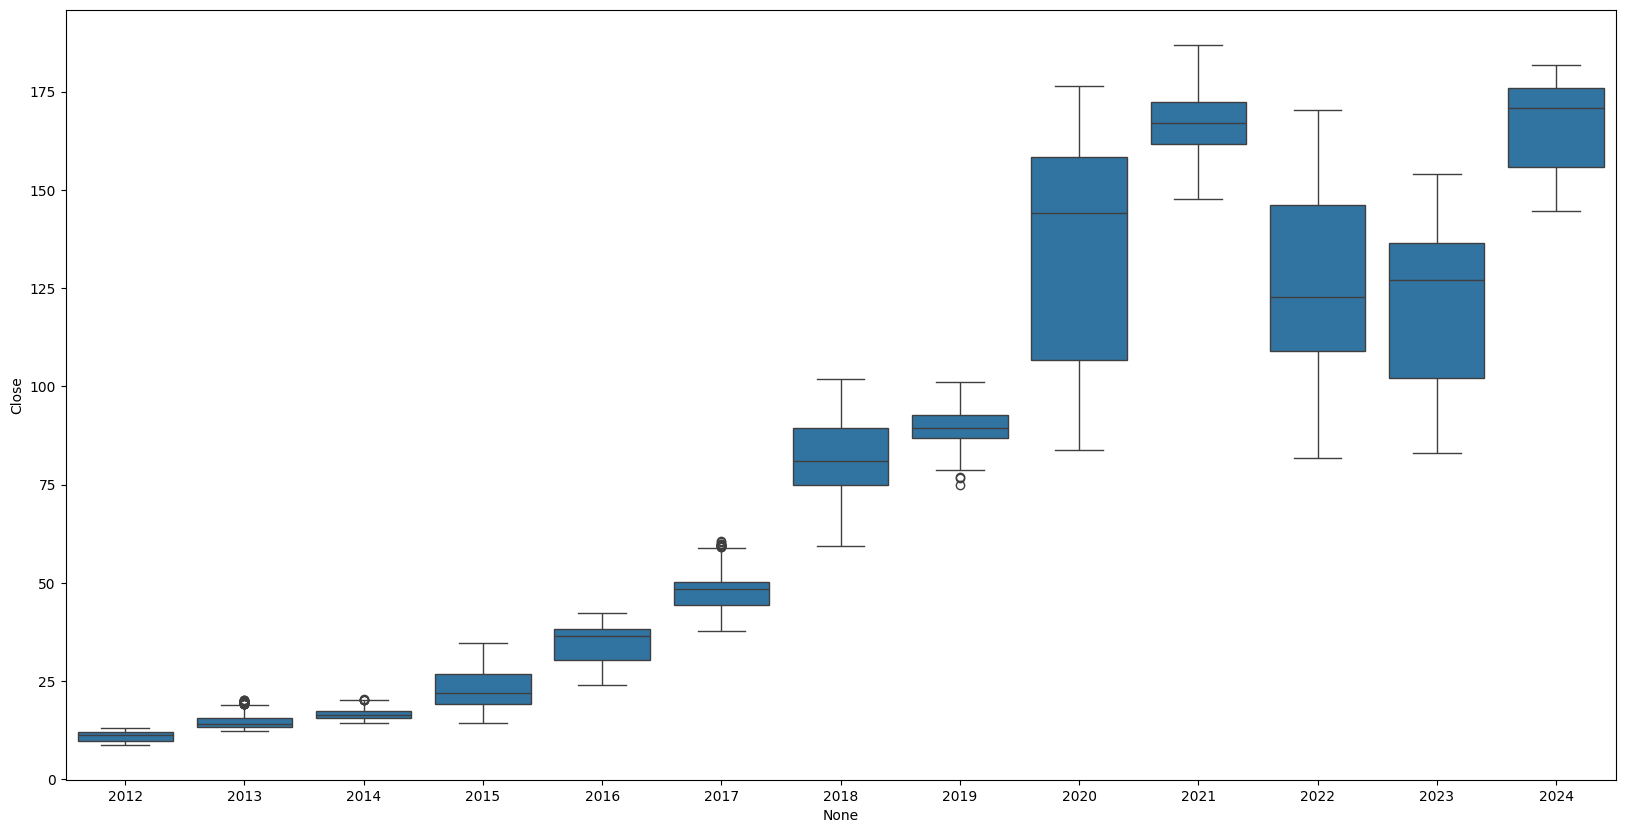

In [ ]:
# price variation for each year
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(x = joined_df_daily.index.year,
                y = joined_df_daily['Close'],
                ax = ax)



* Boxplot of Amazon stock price: we can see from the boxplot above that Amazon stock price generally shows an increasing trend. Interestingly, we noticed that the variance of Amazon stock price seems to increase every year, which is especially prominent after 2020. One possibly reason is that COVID-19 creats a disruptive economic environment which leads to the bigger fluctuation of Amazon stock price.



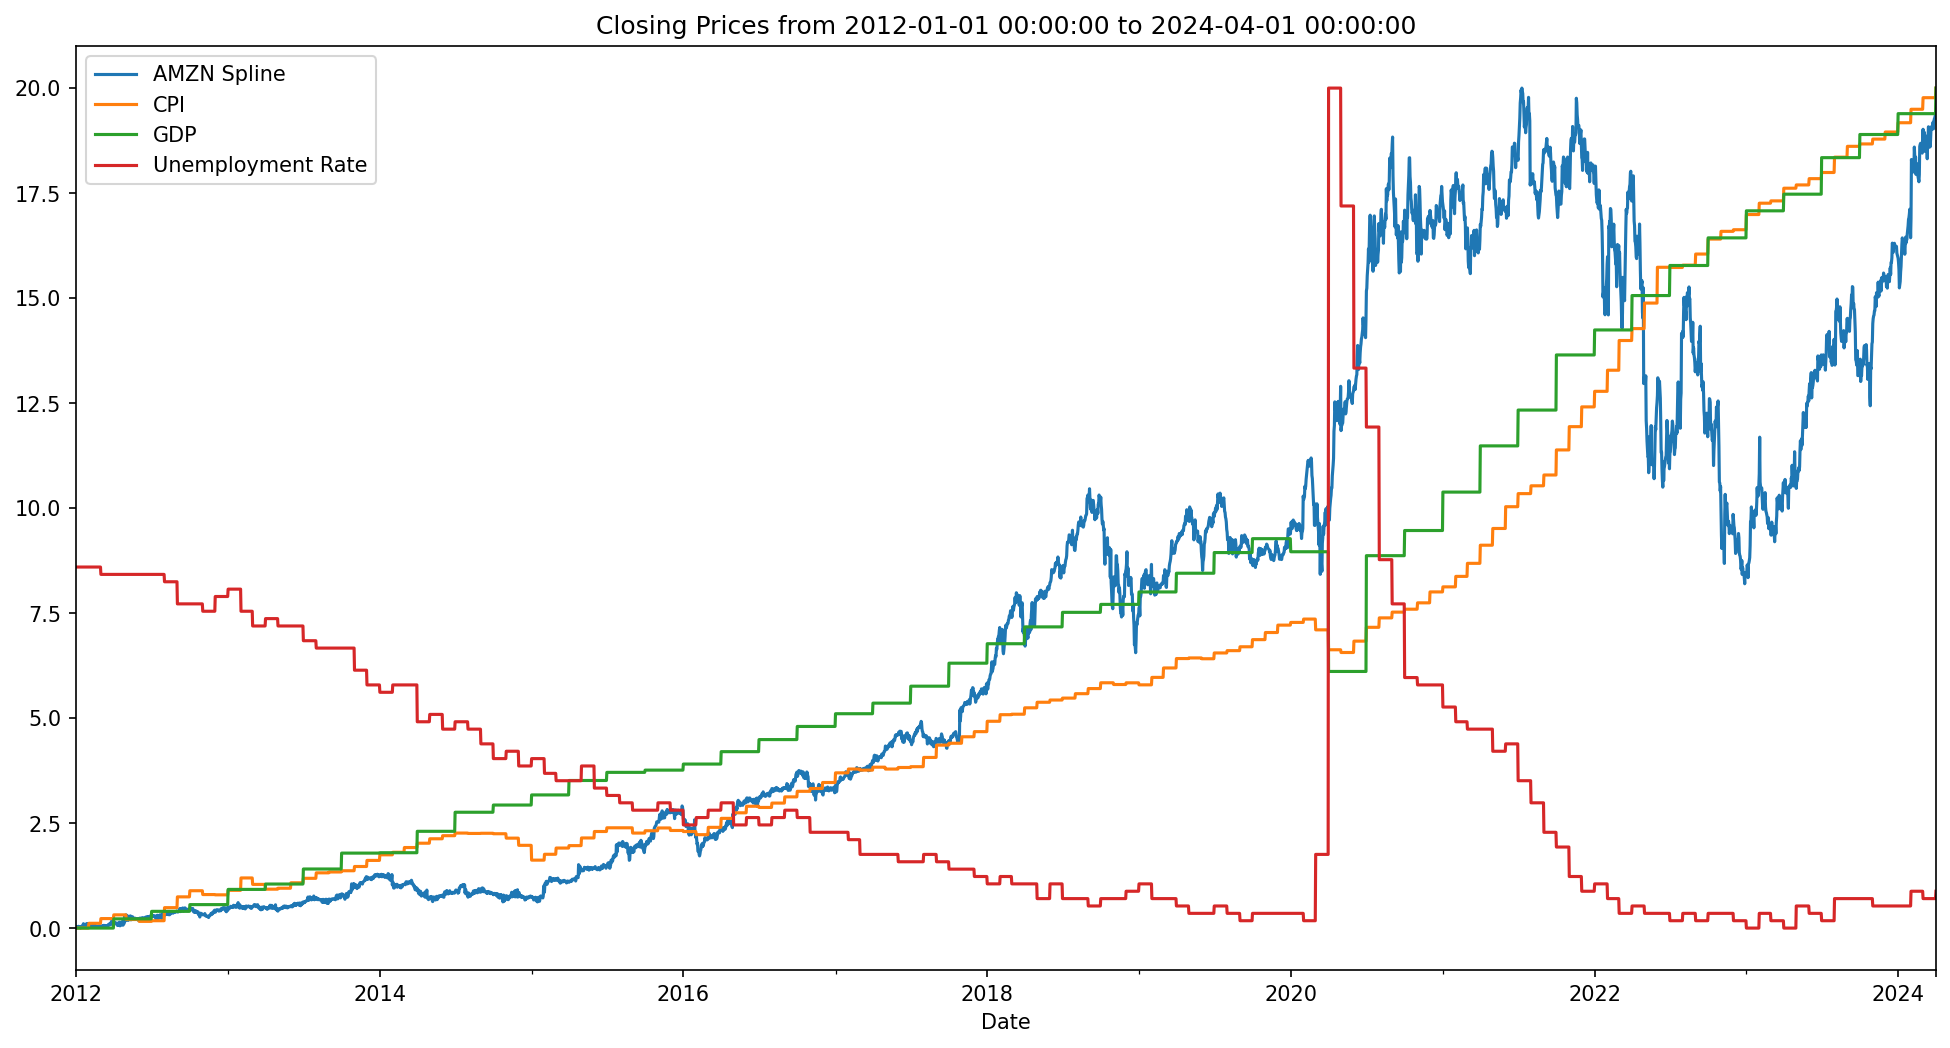

In [ ]:
# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)
# Using plot method to plot close prices.
joined_df_daily_normalized[close_price].plot(label='AMZN Spline')
joined_df_daily_normalized[cpi].plot(label='CPI')
joined_df_daily_normalized[gdp].plot(label='GDP')
joined_df_daily_normalized[unemployment].plot(label='Unemployment Rate')
# adding title to the plot
plt.title(f"""Closing Prices from {start_date} to {end_date}""")
# adding Label to the x-axis
plt.xlabel('Date')
# adding legend to the curve
plt.legend()



* CPI vs. AMZN: The CPI shows a relatively steady and gradual increase throughout the period, reflecting ongoing inflation but without any sharp spikes, suggesting a gradual increase in prices of goods and services in an economy. The steady increase in CPI doesn't appear to have a direct impact on Amazon's stock price, which might suggest that inflationary pressures alone aren't a significant driver for Amazon's stock performance. However, we do see that both the overall trend of CPI and Amazon are increasing over time, suggesting potential other relationships betweem them. For example, stronger CPI means consumers tend to consume more goods, which brings more revenue to companies like Amazon that rely on making profits out of user transactions.
* GDP vs. AMZN: Similar to CPI, GDP shows a steady increase. The trend generally indicates expanding economic environment, which is typically beneficial for business and consumer spending. The increasing GDP seems to be corresponding to the overall increasing stock price of Amazon. This relationship implies that economic growth positively impacts Amazon, likely due to increased consumer spending.
* Unemployment rate vs. AMZN: The Unemployment Rate displays a downward trend before the turning point in 2020 which is COVID-19, suggesting a steadily improving job market conditions. However, COVID-19 significantly worsens the situation because we can see a sharp spike of unemployment rate in 2020. One thing I noticed is that unemployment rate seems to have an inverse relationship with Amazon stock price, which we can see from both pre-covid and post-covid period. Before 2020, the unemployment rate was decreasing and the Amazon stock price was increasing. After a temporary spike in 2020, the unemployment rate continues to decrease and the Amazon stock price also increases. Based on the evidence we have, we cannot say there is a causal relationship between these two.

In general, neither of these three economic factors are very accurate predictors for the Amazon stock price, and unemployment rate seems to be more accuarte than the other two. One reason for this is that these three economic factors each contain part of the information that constitute the change of Amazon stock price, and there are much more information that we don't know and they are not contained in those economic data.





## 4. Create a univariate forecast to predict the stock price.

Run multiple ETS models and evaluate them using 2 other accuracy metrics in addition to RMSE, MAE, and MAPE. Give a brief explanation of why you chose those 2 additional accuracy metrics. Explain which models work best and why?

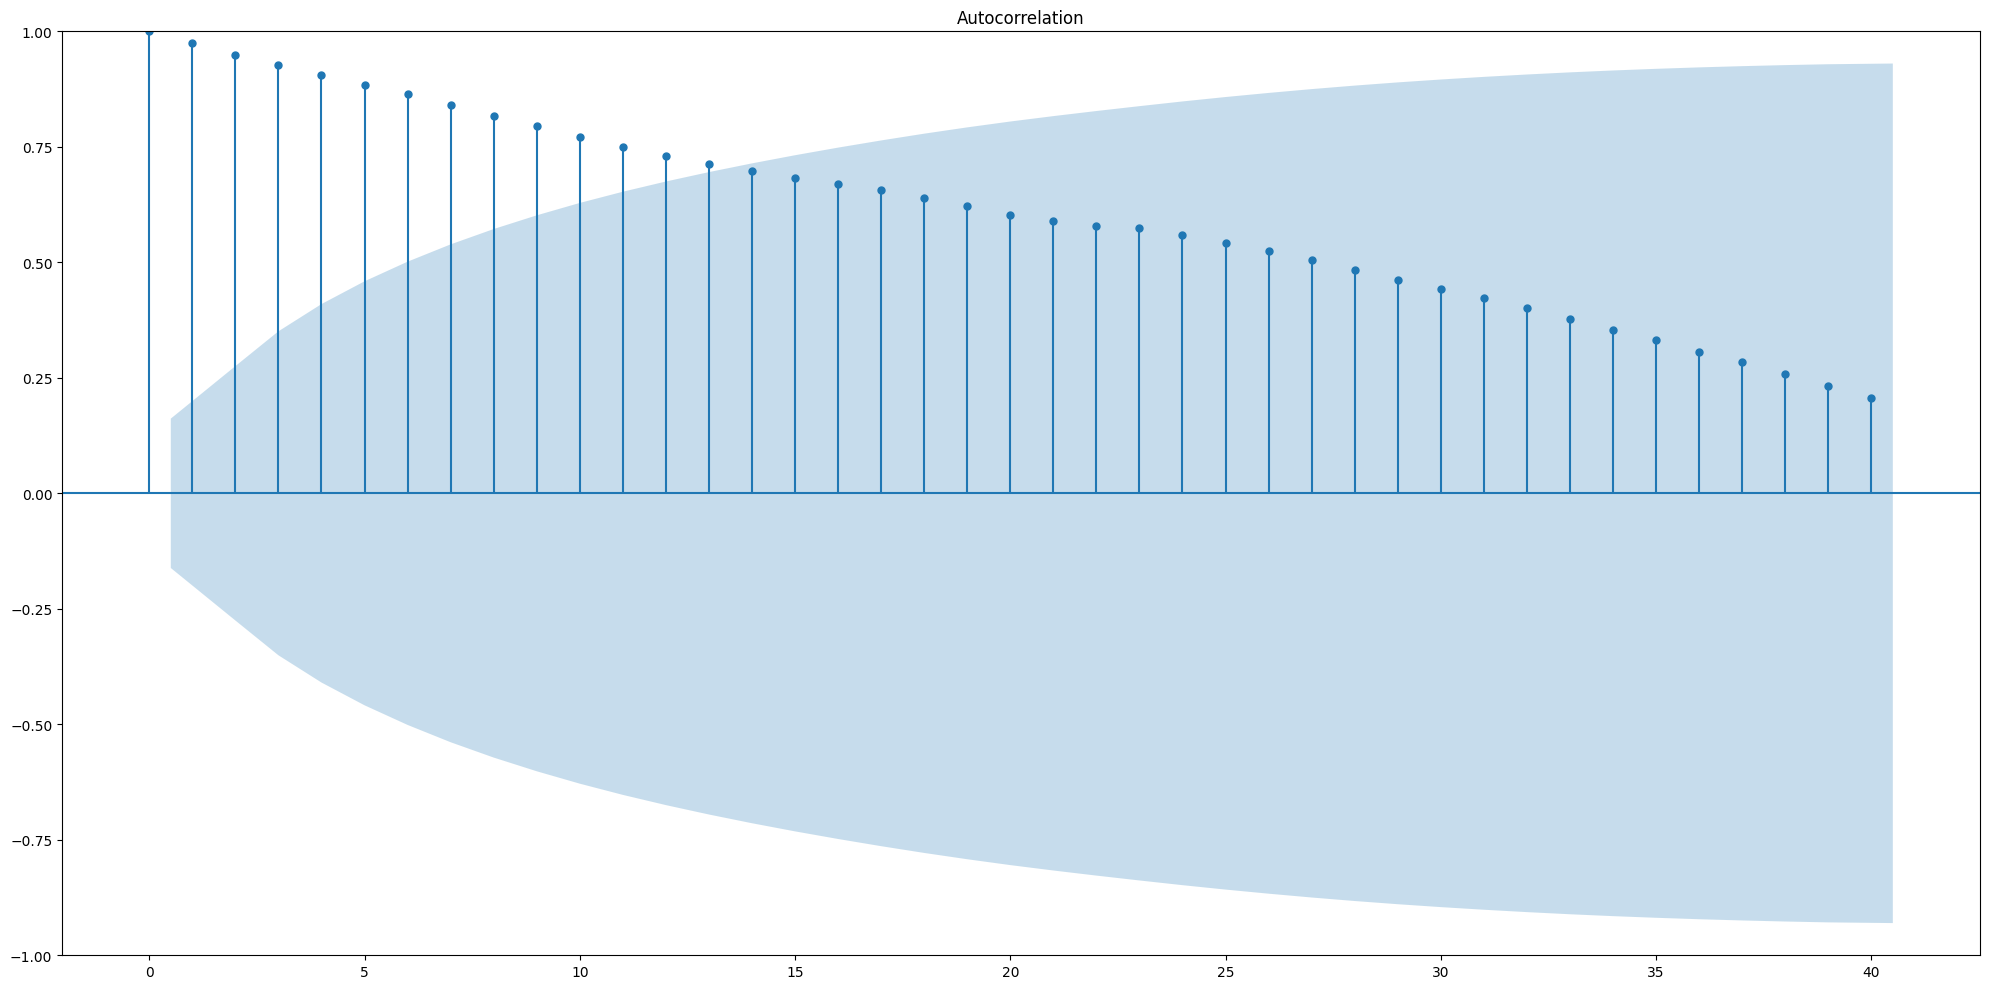

In [ ]:
# Draw an ACF plot to identify trends in data and the influence of previously observed values on a current observation.
fig = plot_acf(joined_df_monthly[close_price], lags=40)
fig.set_size_inches((20, 10))
# Tight layout to realign things
fig.tight_layout()
plt.show()

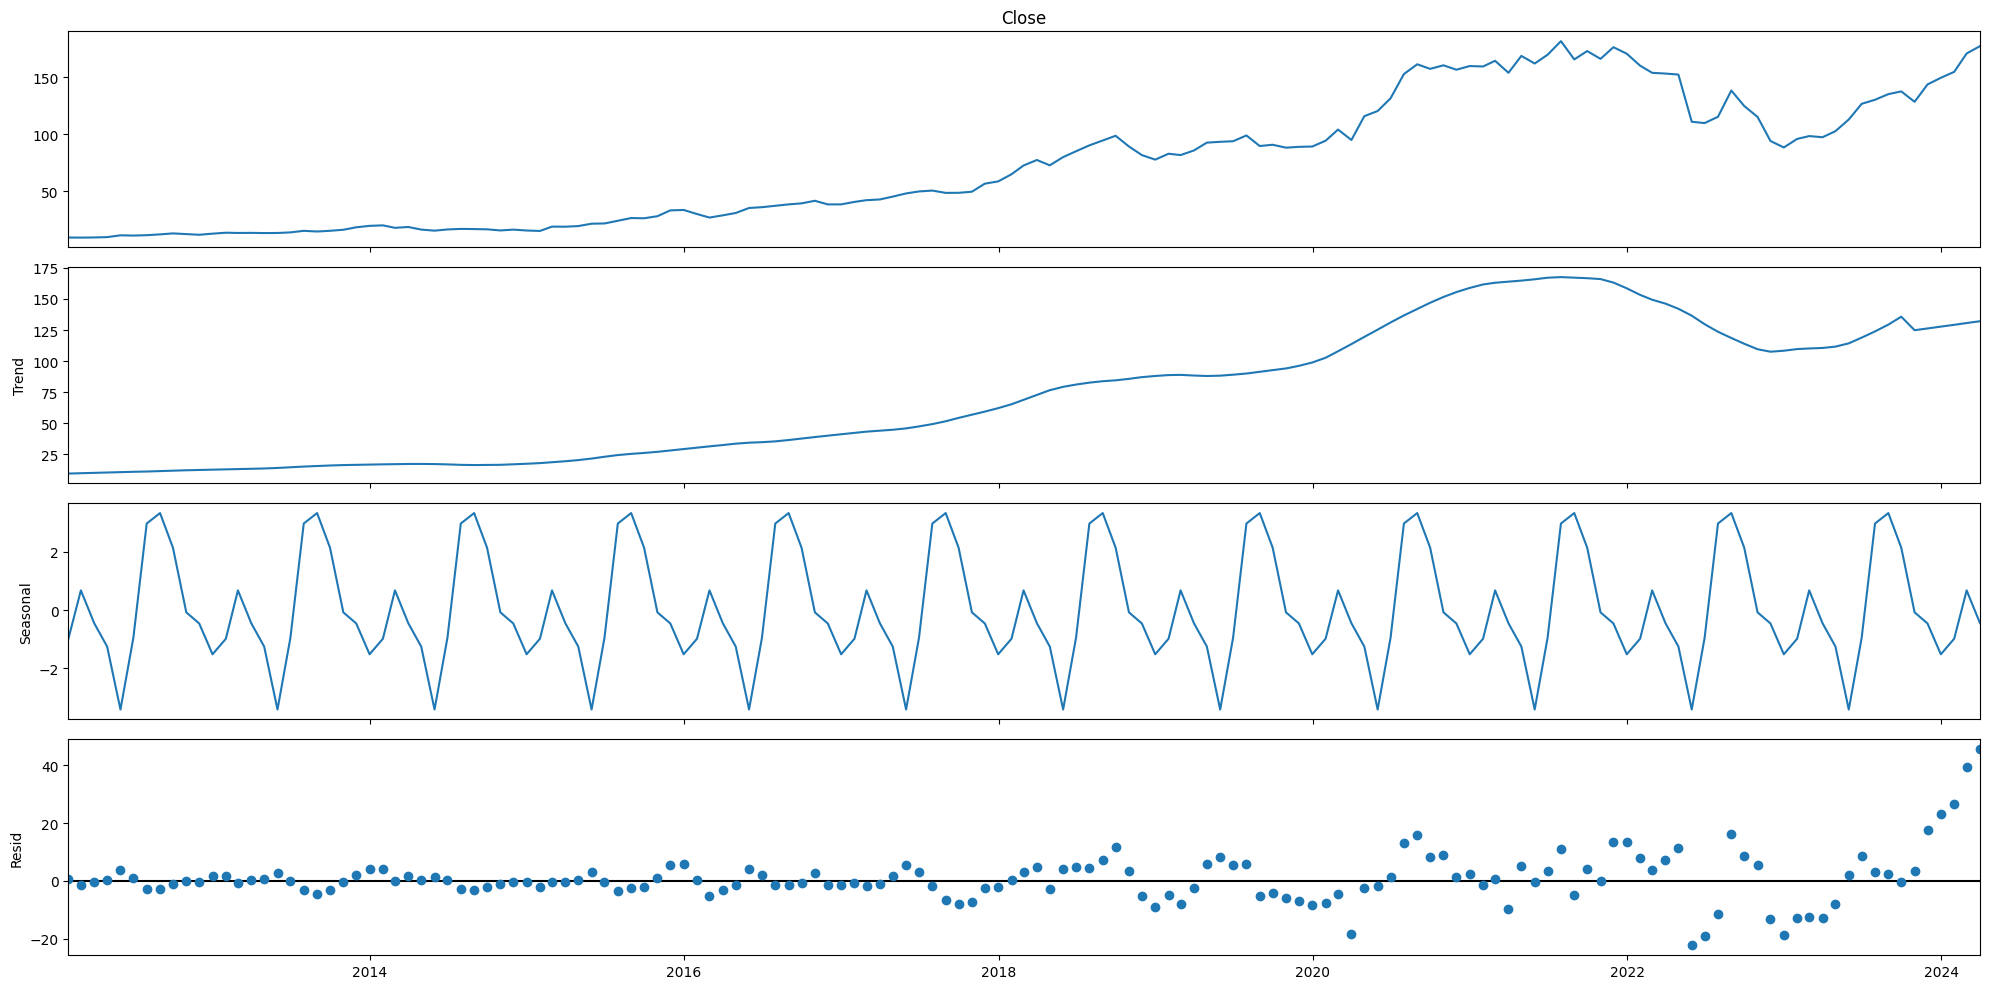

In [ ]:
# Plot time series decomposition to see trend, sesonality, and residual
res = sm.tsa.seasonal_decompose(joined_df_monthly[close_price], period=12, extrapolate_trend='freq')
fig = res.plot()
fig.set_size_inches((20, 10))
# Tight layout to realign things
fig.tight_layout()
plt.show()


* Trend: There's a clear upward trend, indicating that over the years, Amazon’s stock price has generally been increasing.
* Seasonality: There are recurring fluctuations throughout each year, which is possibily associated with variations in buying behavior during different seasons
* Residual: The residuals seem mostly scattered around zero with no clear pattern, which means there is not much information left that the trend and seasonality did not catch.



In [ ]:
# Create a dataframe with close_price column only
df_close = joined_df_monthly[[close_price]]
# Create a test set of 12 data points
train_data, test_data = train_test_split(df_close, test_size=test_size, random_state=25, shuffle = False)
print(f"No. of training examples: {train_data.shape[0]}")
print(f"No. of testing examples: {test_data.shape[0]}")
print(train_data)

No. of training examples: 135
No. of testing examples: 12
                Close
2012-01-31   9.217500
2012-02-29   9.141000
2012-03-31   9.264250
2012-04-30   9.554250
2012-05-31  11.147750
...               ...
2022-11-30  93.949997
2022-12-31  88.250000
2023-01-31  95.755001
2023-02-28  98.239998
2023-03-31  97.239998

[135 rows x 1 columns]


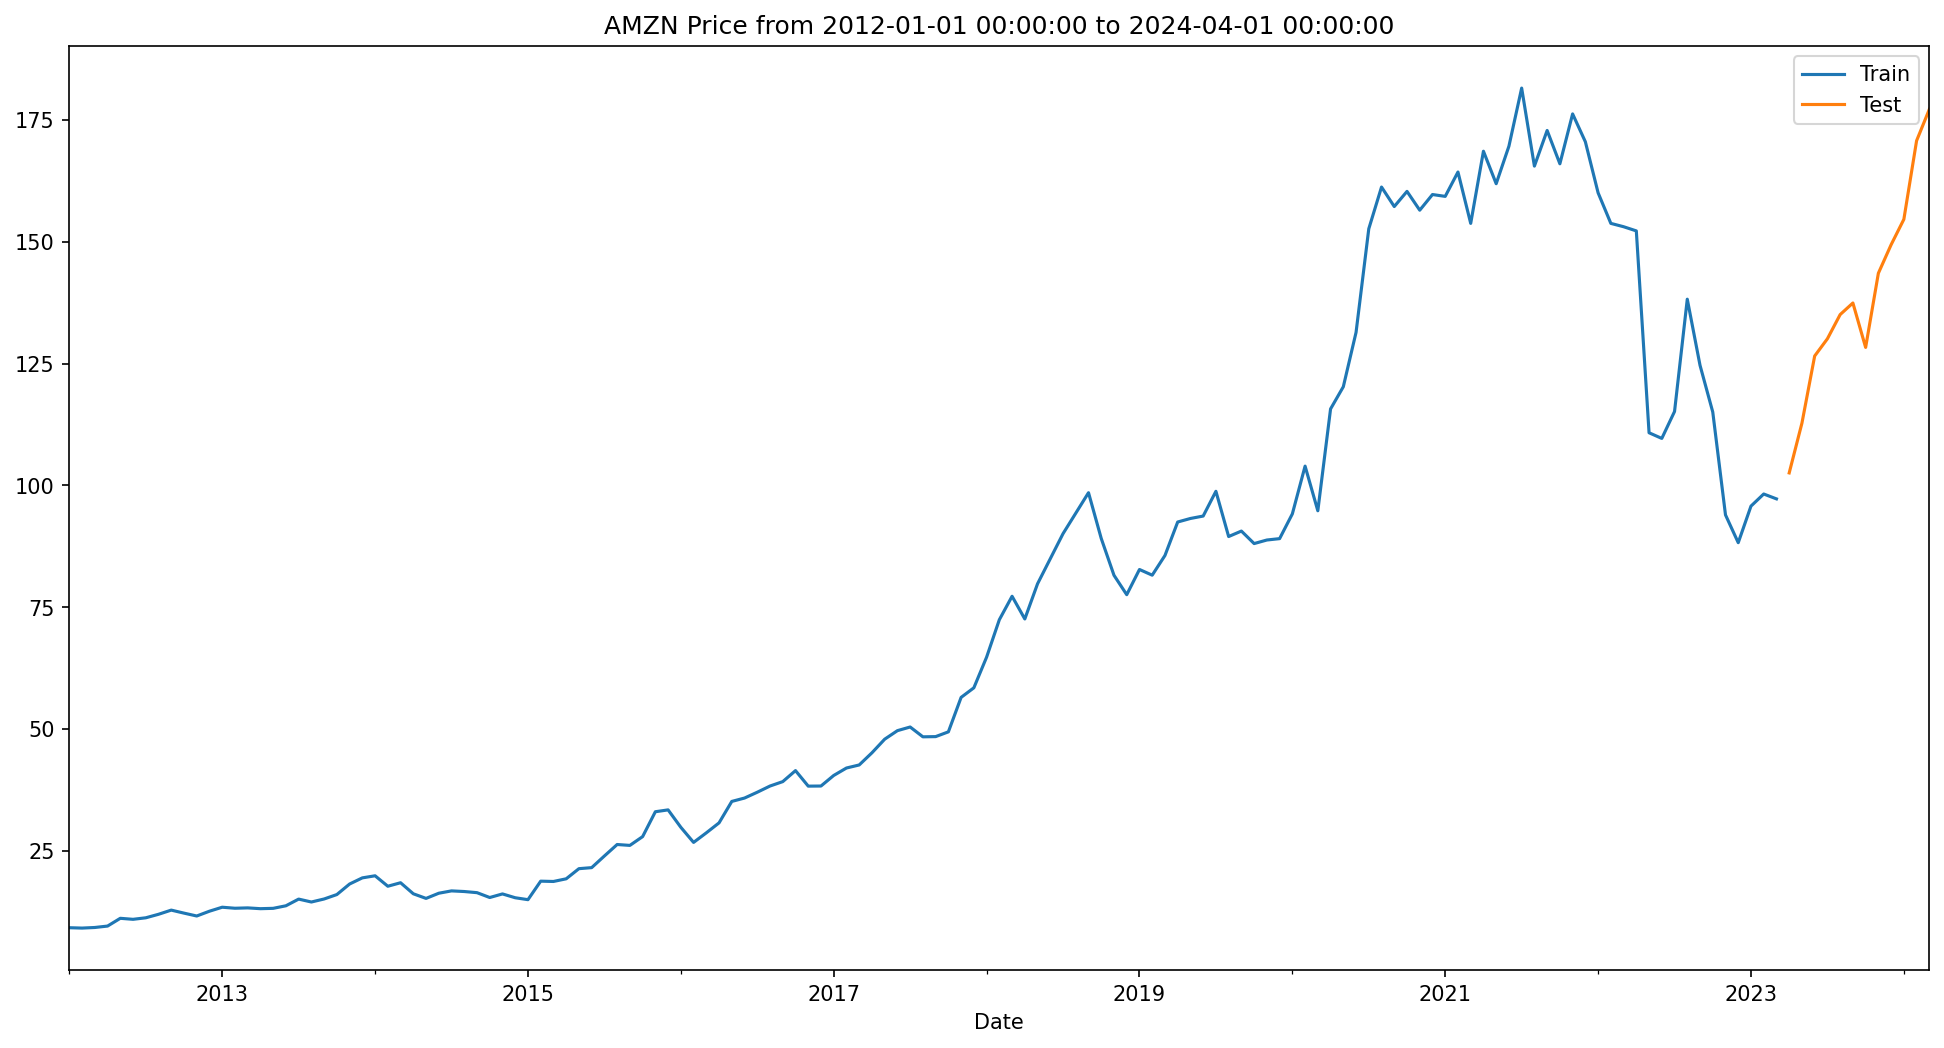

In [ ]:
#Plot train and test data
# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)
# using plot method to plot close prices.
# in plot method we set the label and color of the curve.
train_data[close_price].plot(label='Train')
test_data[close_price].plot(label='Test')
# adding title to the plot
plt.title(f"""{stock_name} Price from {start_date} to {end_date}""")
# adding Label to the x-axis
plt.xlabel('Date')
# adding legend to the curve
plt.legend()

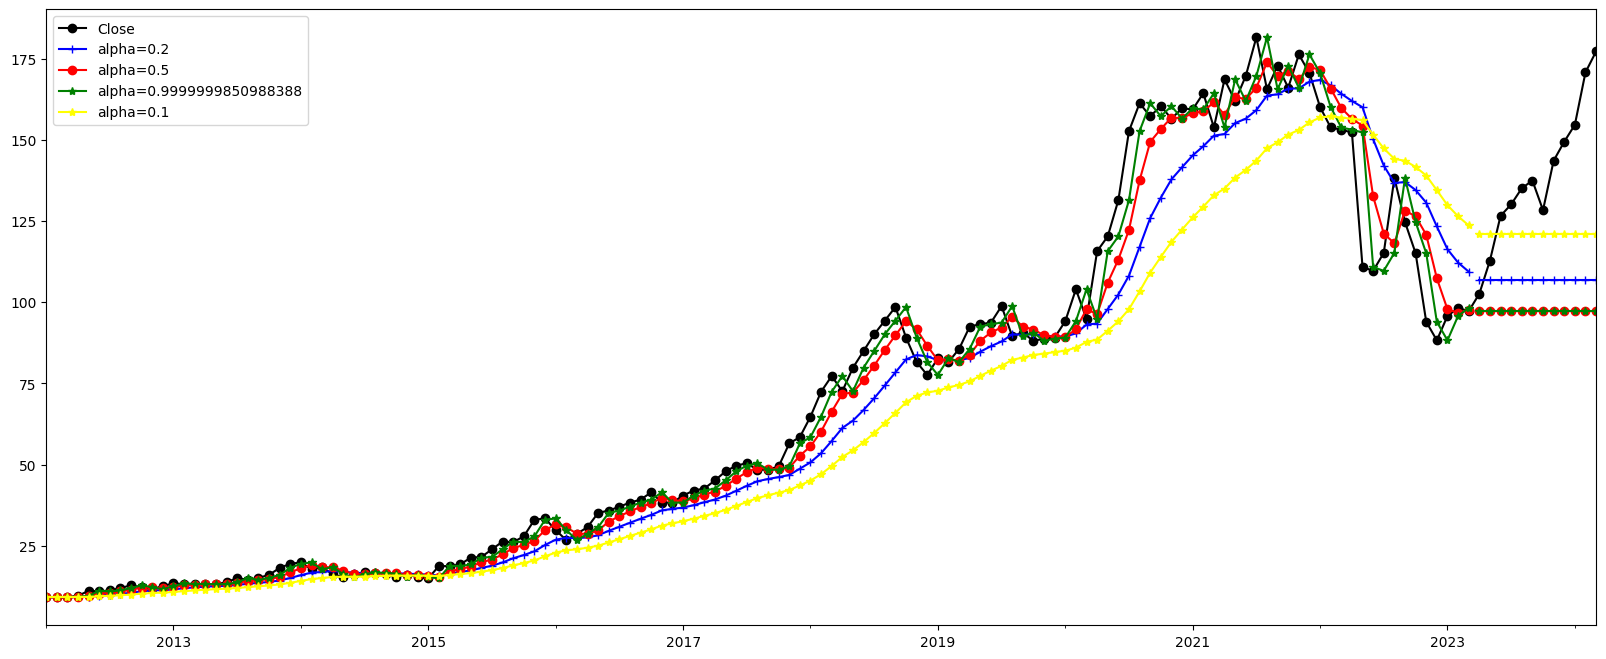

In [ ]:
# Initialize three simple exponential smoothing model with optimized smoothing level
# First Instance
ins1 = SimpleExpSmoothing(train_data).fit(smoothing_level=0.2,optimized=False)
ins_cast1 = ins1.forecast(test_size).rename('alpha=0.2')
# Second Instance
ins2 = SimpleExpSmoothing(train_data).fit(smoothing_level=0.5,optimized=False)
ins_cast2 = ins2.forecast(test_size).rename('alpha=0.5')
# Third Instance
ins3 = SimpleExpSmoothing(train_data).fit(smoothing_level=None,optimized=True)
ins_cast3 = ins3.forecast(test_size).rename('alpha=%s'%ins3.model.params['smoothing_level'])
# Fourth Instance
ins4 = SimpleExpSmoothing(train_data).fit(smoothing_level=0.1,optimized=False)
ins_cast4 = ins4.forecast(test_size).rename('alpha=0.1')


# Visualize these three models
ax = df_close.plot(marker='o', color='black', figsize=(20,8), legend=True)

#Plot for alpha =0.2
ins_cast1.plot(marker='+', ax=ax, color='blue', legend=True)
ins1.fittedvalues.plot(marker='+', ax=ax, color='blue')

#Plot for alpha = 0.5
ins_cast2.plot(marker='o', ax=ax, color='red', legend=True)
ins2.fittedvalues.plot(marker='o', ax=ax, color='red')

#Plot for alpha=Optimized by statsmodel
ins_cast3.plot(marker='*', ax=ax, color='green', legend=True)
ins3.fittedvalues.plot(marker='*', ax=ax, color='green')

#Plot for alpha=0.1
ins_cast4.plot(marker='*', ax=ax, color='yellow', legend=True)
ins4.fittedvalues.plot(marker='*', ax=ax, color='yellow')

plt.show()



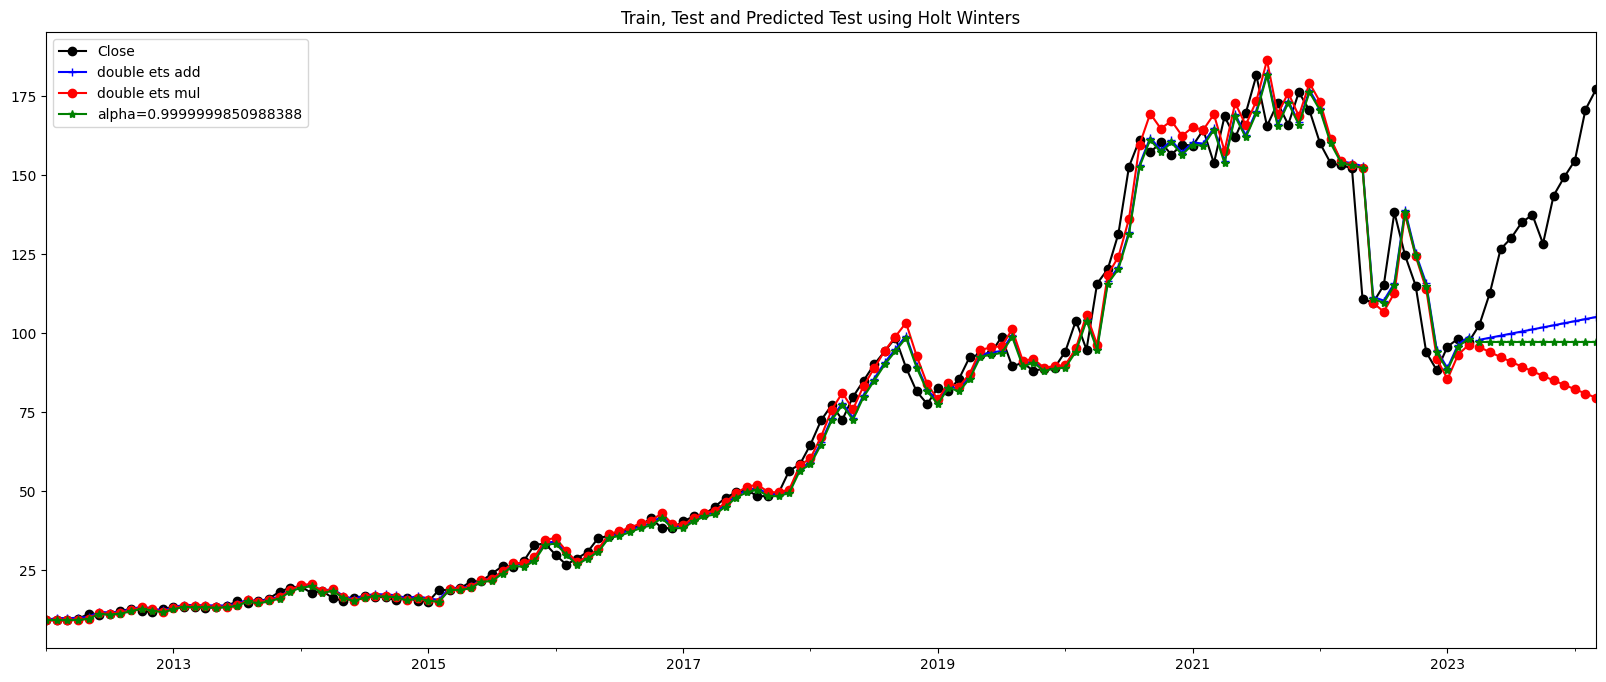

In [ ]:
# Initialize two double exponential smoothing model, one with additive trend and the other with multiplicative trend
double_ets_add = ExponentialSmoothing(train_data, trend = 'add').fit()
double_ets_mul = ExponentialSmoothing(train_data, trend = 'mul').fit()
double_ets_add_pred = double_ets_add.forecast(test_size)
double_ets_mul_pred = double_ets_mul.forecast(test_size)


# Visualize these two double ETS models
ax = df_close.plot(marker='o', color='black', figsize=(20,8), legend=True)
#Plot for double ETS additive

double_ets_add_pred.plot(marker='+', ax=ax, color='blue', legend=True, label = 'double ets add')
double_ets_add.fittedvalues.plot(marker='+', ax=ax, color='blue')
#Plot for double ETS multiplicative

double_ets_mul_pred.plot(marker='o', ax=ax, color='red', legend=True, label = 'double ets mul')
double_ets_mul.fittedvalues.plot(marker='o', ax=ax, color='red')

#Plot for simple exponential smooting alpha=Optimized by statsmodel
ins_cast3.plot(marker='*', ax=ax, color='green', legend=True)
ins3.fittedvalues.plot(marker='*', ax=ax, color='green')
plt.title('Train, Test and Predicted Test using Holt Winters')
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


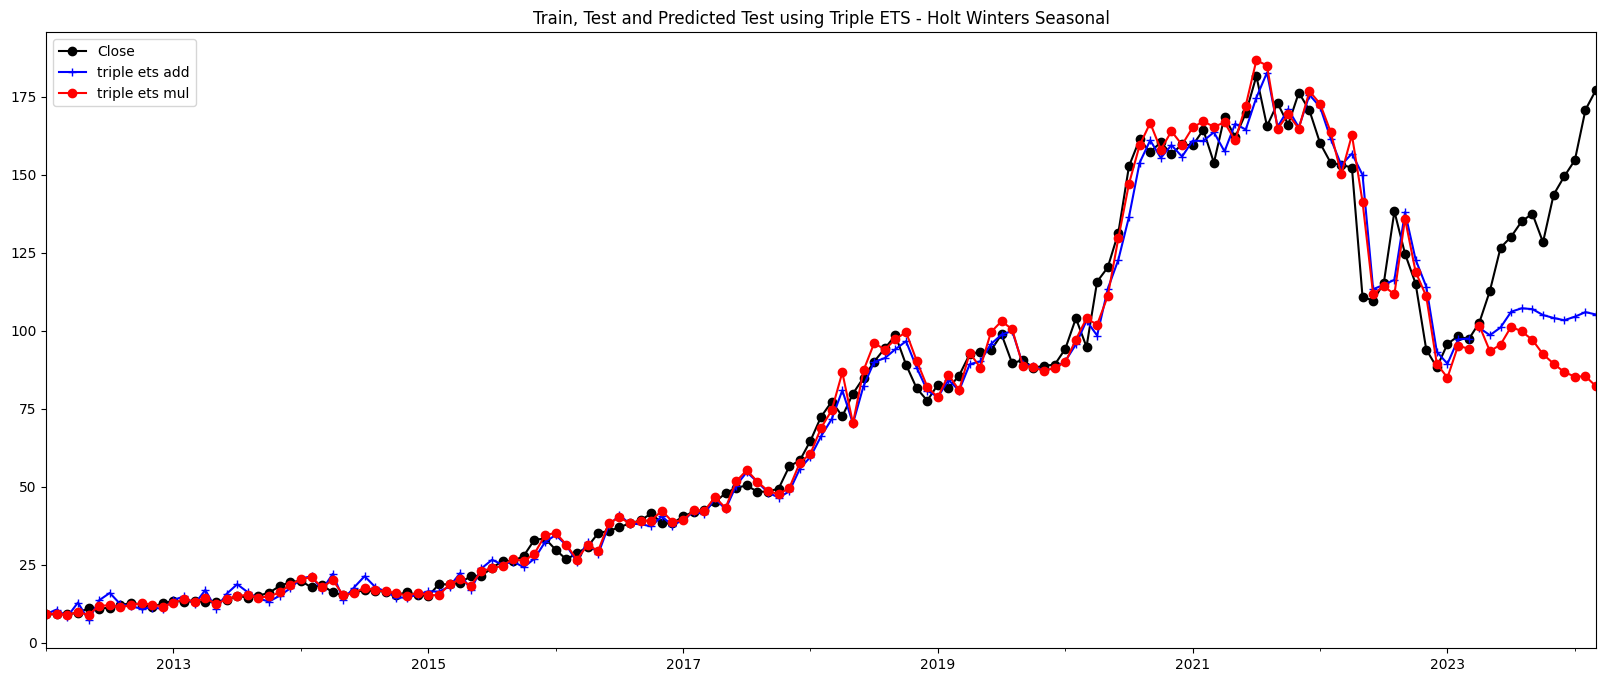

In [ ]:
# Initialize two triple ETS models, one with additive trend and the other with multiplicative trend
triple_ets_add = ExponentialSmoothing(train_data, trend = 'add', seasonal = 'add', seasonal_periods=12).fit()
triple_ets_mul = ExponentialSmoothing(train_data, trend = 'mul', seasonal = 'mul', seasonal_periods=12).fit()
triple_ets_add_pred = triple_ets_add.forecast(test_size)
triple_ets_mul_pred = triple_ets_mul.forecast(test_size)

ax = df_close.plot(marker='o', color='black', figsize=(20,8), legend=True)

#Plot for double ETS additive
triple_ets_add_pred.plot(marker='+', ax=ax, color='blue', legend=True, label = 'triple ets add')
triple_ets_add.fittedvalues.plot(marker='+', ax=ax, color='blue')

#Plot for double ETS multiplicative
triple_ets_mul_pred.plot(marker='o', ax=ax, color='red', legend=True, label = 'triple ets mul')
triple_ets_mul.fittedvalues.plot(marker='o', ax=ax, color='red')

#Plot for simple exponential smooting alpha=Optimized by statsmodel
#ins_cast3.plot(marker='*', ax=ax, color='green', legend=True)
#ins3.fittedvalues.plot(marker='*', ax=ax, color='green')
plt.title('Train, Test and Predicted Test using Triple ETS - Holt Winters Seasonal')
plt.show()

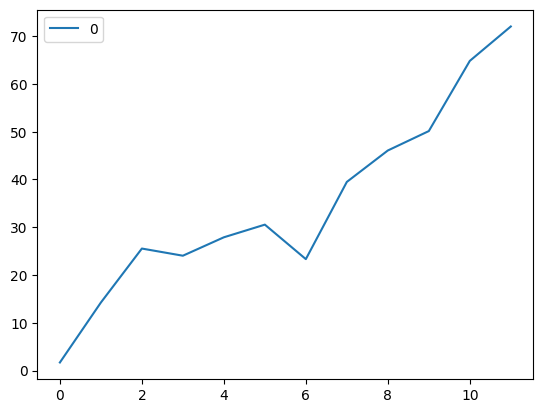

In [ ]:
# Calculate time series residual errors
residuals = [test_data.values.flatten()[i]-triple_ets_add_pred.values.flatten()[i] for i in range(len(test_data))]
residuals = pd.DataFrame(residuals)
# Visualize residual errors using a line plot
residuals.plot()
plt.show()

In [ ]:
# Define metrics dataframe which will be used below for storing results
metrics_dataframe = pd.DataFrame(columns=['Model', 'RMSE', 'MAE', 'MAPE'])

def metrics_cal(actuals, predictions, model):
    mse = mean_squared_error(actuals, predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    wape = np.sum(np.abs(actuals - predictions)) / np.sum(np.abs(actuals))
    denominator = (np.abs(actuals)+np.abs(predictions))/2.0
    smape = 2 * np.mean(np.abs(predictions - actuals) / denominator) * 100
    df = pd.DataFrame({'Model': [model],
                'RMSE': [rmse],
                'MAE': [mae],
                'MAPE': [mape],
                'WAPE': [wape],
                'SMAPE': [smape]})

    global metrics_dataframe
    metrics_dataframe = pd.concat([metrics_dataframe, df], ignore_index=True)
    return metrics_dataframe


# Get all the metrics to evaluate model performance on training data
metrics_dataframe = metrics_cal(test_data.values.flatten(),ins_cast4.values.flatten(),'Simple 0.1')
metrics_dataframe = metrics_cal(test_data.values.flatten(),ins_cast1.values.flatten(),'Simple 0.2')
metrics_dataframe = metrics_cal(test_data.values.flatten(),ins_cast2.values.flatten(),'Simple 0.5')
metrics_dataframe = metrics_cal(test_data.values.flatten(),ins_cast3.values.flatten(),'Simple 1')
metrics_dataframe = metrics_cal(test_data.values.flatten(),double_ets_add_pred.values.flatten(),'Double Add')
metrics_dataframe = metrics_cal(test_data.values.flatten(),double_ets_mul_pred.values.flatten(),'Double Mul')
metrics_dataframe = metrics_cal(test_data.values.flatten(),triple_ets_add_pred.values.flatten(),'Triple Add')
metrics_dataframe = metrics_cal(test_data.values.flatten(),triple_ets_mul_pred.values.flatten(),'Triple Mul')

# Sort the dataframe by MAE
metrics_dataframe.sort_values(by='MAE')

<ipython-input-14-99f13b283446>:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_dataframe = pd.concat([metrics_dataframe, df], ignore_index=True)


,Model,RMSE,MAE,MAPE,WAPE,SMAPE
0,Simple 0.1,27.579653,22.482243,15.176640,0.161701,33.197909
1,Simple 0.2,38.257374,32.804492,22.006982,0.235943,51.047196
6,Triple Add,40.078667,34.985337,23.613557,0.251628,55.147864
4,Double Add,41.927778,37.526192,25.547230,0.269903,59.995990
2,Simple 0.5,46.590607,41.661560,28.349174,0.299646,67.923403
3,Simple 1,46.710715,41.795835,28.447978,0.300612,68.189921
7,Triple Mul,53.483986,46.528472,31.367271,0.334651,77.822003
5,Double Mul,57.715786,51.678973,35.184488,0.371695,88.585622


In [ ]:
# Create a data frame with all the predictions along with the test data
test_pred_df = test_data.copy()
# Add all predictions
test_pred_df = test_pred_df.assign(triple_ets_mul_pred = triple_ets_mul_pred.values.flatten(),
                    SimpleExp_1_pred = ins_cast3.values.flatten(),
                    double_ets_add_pred = double_ets_add_pred.values.flatten())
# Create an average prediction from the three and check it's metrics
test_pred_df['Average_Predictions'] = (test_pred_df['SimpleExp_1_pred']+test_pred_df['triple_ets_mul_pred']+test_pred_df['double_ets_add_pred'])/3
# Evaluate model performance on test data
metrics_dataframe = metrics_cal(test_data.values.flatten(),test_pred_df['Average_Predictions'].values.flatten(),'Average')
metrics_dataframe.sort_values(by='MAE')

,Model,RMSE,MAE,MAPE,WAPE,SMAPE
0,Simple 0.1,27.579653,22.482243,15.176640,0.161701,33.197909
1,Simple 0.2,38.257374,32.804492,22.006982,0.235943,51.047196
6,Triple Add,40.078667,34.985337,23.613557,0.251628,55.147864
4,Double Add,41.927778,37.526192,25.547230,0.269903,59.995990
2,Simple 0.5,46.590607,41.661560,28.349174,0.299646,67.923403
3,Simple 1,46.710715,41.795835,28.447978,0.300612,68.189921
8,Average,47.329609,41.950166,28.454160,0.301722,68.461142
7,Triple Mul,53.483986,46.528472,31.367271,0.334651,77.822003
5,Double Mul,57.715786,51.678973,35.184488,0.371695,88.585622


1. Why choose SMAPE: SMAPE is an adjustment of MAPE, which averages the absolut percentage errors by the average of the corecats and observed values. This approach treats over-forecasts and under-forecasts equally, hence providing a more balanced error metric that can use very useful when some data are close to zero. So basically it can be used as a supplement way to evaluate model accuracy from another perspective.

2. Why choose WAPE: WAPE is the weighted absolute percentage error, which means it weights the absolute errors by the total actual values, providing a measure of accuracy relative to the size of the data. This is a huge benefit because it offers us a accuracy measure that is not biased by the absolute size of the data. Lower WAPE values suggest a model is more accurate. So in general, WAPE is a robustm, practical, and easily interpretable measure that address some of the disadvantages of MAPE and MSE.

3. Which model works best and why: After we rank all the models by MAE in acending order, we can see that the simple 0.1 model has the lowest MAE value, as well as the lowest value in other measures. This suggests that it might be the most reliable model for our stock prediction task. Besides, we noticed that for simple exponential smoothing models, the smaller the alpha value the more accurate the model is. By looking at the visualization which includes all the simple exponential smoothing models, we can see the test data stock price actually goes up a lot, and right before that there is a huge downward trend. In this case, bigger alpha value would mean weighting the most recent data (which is downward trend) more heavily compared to previous data, which is not what happens when we look at the test data. So small alpha value takes the average of all the historical data, making the prediction more accurate compared to other models. We also see that the triple mul model and double mul model performs poorly compared to other models, indicating that combining seasonality into prediction model may not be suitable for this dataset, and the extra model complexity does not help to explain more the pattern in the data. Based on the observations above, we decide that simple 0.1 model is the best for our analysis.